In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
import math
from scipy import stats
from pathlib import Path

plt.rcParams['font.family'] = 'arial'
plt.rcParams['font.size'] = 10

In [2]:
def load_logs(subfolderName, fileExtension):
    
    # Gets all txt files in the sub folder
    # and extracts information about beam conditions
    
    # Find the subfolders (corresponding to beam conditions) within subfolderName
    subsubfolders = list(subfolderName.glob("*"))
    
    beaminfo = [None] * len(subsubfolders)
    current_density = [None]*len(subsubfolders)
    
    for i in range(len(subsubfolders)):
        beaminfo[i] = subsubfolders[i].stem
        nA = float(beaminfo[i].split('nA_')[0])
        um = float(beaminfo[i].split('_')[1].split('um')[0])
        
        spot_area_um = np.pi*((um/2)**2)
        current_density[i] = nA/spot_area_um
    
    mydata = [None] * len(beaminfo)
    
    for i in range(len(beaminfo)):
        myfiles = list(subsubfolders[i].glob('*.' + fileExtension))
        
        mydata[i] = [None] * len(myfiles)

        # Import as pandas data frames
    
        for j in range(len(myfiles)):
            mydata[i][j] = pd.read_csv(myfiles[j], delimiter = '\t')
            mydata[i][j].columns = ["DateTime", "CCounts", "NCounts"]
        
    return beaminfo, mydata, current_density

In [3]:
def mean_logs(mydata):
    
    # Finds average, stdev and sterr of each set of data (different beam conditions)
    
    ncounts_concat = [None]*len(mydata)
    ncounts_mean = [None]*len(mydata)
    ncounts_se = [None]*len(mydata)
    ncounts_stdev = [None]*len(mydata)
    Ncounts = [None]*len(mydata)
    
    for n in range(len(mydata)):
        # Set the first column of data
        ncounts_concat[n] = mydata[n][0].NCounts
    
        for i in range(len(mydata[n])-1):
            ncounts_concat[n] = pd.concat((ncounts_concat[n], mydata[n][i+1].NCounts), axis=1)
        
        # Trim the concat array to drop rows containing NaN
        ncounts_concat[n] = ncounts_concat[n].dropna(how='any')
        
        # Take mean, se, stdev
        ncounts_mean[n] = ncounts_concat[n].mean(axis=1)
        ncounts_se[n] =  stats.sem(ncounts_concat[n], axis=1)
        ncounts_stdev[n] = np.std(ncounts_concat[n], axis=1)
        
        # Turn these into a data frame
        Ncounts[n] = pd.DataFrame([np.array(ncounts_mean[n]),
                                np.array(ncounts_se[n]),
                                np.array(ncounts_stdev[n])])
        
        Ncounts[n] = Ncounts[n].transpose()
        Ncounts[n].columns = ["mean","se","stdev"]
               
        seconds_per_point = 1.93
        Ncounts[n]['time'] = Ncounts[n].index * seconds_per_point
        
    return Ncounts

In [75]:
def plot_log_sets(Ncounts, sampleName, current_density, beaminfo, ax, legend=True):
    
    plt.sca(ax)
    
    for i in range(len(Ncounts)):

        plt.errorbar(x=Ncounts[i]['time'], y=Ncounts[i]['mean'],
                     yerr=Ncounts[i]['stdev'],
                     ecolor=[0.8,0.8,0.8],
                     label='{:.1f} ({} nA)'.format(current_density[i], int(beaminfo[i].split('nA')[0]))
                     )

    if legend:
        
        plt.legend(fontsize=8)

        handles, labels = ax.get_legend_handles_labels()

        ax.legend(handles[::-1], labels[::-1],
                  title='Current density'
                  , fontsize=9
                  , loc='upper left'
                  , ncols=2
                  , bbox_to_anchor=(0,-0.3)
                #   , frameon=False
                  , markerfirst=False
                  , borderpad=0.4
                  , labelspacing=0.4
                  , columnspacing=1
                  , handletextpad=0.4
                  , framealpha=1
                  )

    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('cps', fontsize=12)
    # plt.title(sampleName, fontsize=12, loc="left")


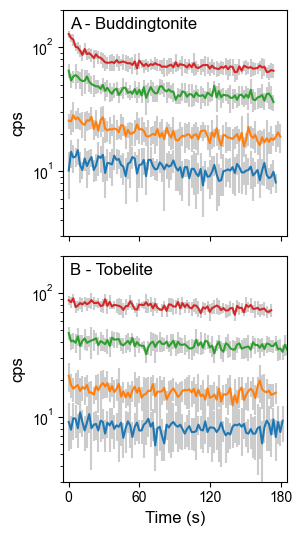

In [90]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8*0.39, 14*0.39), sharex=True)
axs = axs.ravel()

beaminfo, mydata, current_density = load_logs(subfolderName=Path('../data/raw/countlogs_Edi/budd_logs'), fileExtension='txt')
Ncounts = mean_logs(mydata)
plot_log_sets(Ncounts, 'Buddingtonite', current_density, beaminfo, axs[0], legend=False)

beaminfo, mydata, current_density = load_logs(subfolderName=Path('../data/raw/countlogs_Edi/tobe_logs'), fileExtension='txt')
Ncounts = mean_logs(mydata)
plot_log_sets(Ncounts, 'Tobelite', current_density, beaminfo, axs[1], legend=False)

for ax in axs:
    ax.set_xlim(-5,185)
    ax.set_xticks(np.arange(0, 240, 60))
    ax.set_ylabel('cps', fontsize=12)
    # ax.set_xlabel('Time (s)', fontsize=12)

# alphalabel = 'ABCDEFGHIJ'
subplot_labels = ['A - Buddingtonite', 'B - Tobelite']

for i in range(2):
    axs[i].text(0.03, 0.97, subplot_labels[i], ha='left', va='top', transform=axs[i].transAxes, fontsize=12)

axs[0].set_ylim(3,200)
axs[1].set_ylim(3,200)

axs[0].set_yscale("log")
axs[0].set_xlabel(None)

axs[1].set_yscale("log")
axs[1].set_xlabel('Time (s)', fontsize=12)

plt.tight_layout()

# plt.legend(fontsize=8)

# handles, labels = axs[1].get_legend_handles_labels()

# axs[1].legend(handles[::-1], labels[::-1],
#             title='Current density'
#             , fontsize=9
#             , loc='upper right'
#             # , ncols=2
#             , bbox_to_anchor=(1,1.25)
#         #   , frameon=False
#             , markerfirst=False
#             , borderpad=0.4
#             , labelspacing=0.4
#             , columnspacing=1
#             , handletextpad=0.4
#             , framealpha=1
#             )

plt.savefig('../figures/fig_countlogs_budd_tobe.pdf')

Figure showing logs for glass, cs- and pb- nitrates

In [6]:
subfolders = ['tobe_logs',
 'mallik_logs',
 'csnitr_logs',
 'bn_logs',
 'sin_logs',
 'budd_logs',
 'tobesio2_logs',
 'gan_logs',
 'pbnitr_logs']

sampleNames = ['Tobelite','Glass','CsNitrate',
                'BN','Si3N4','Buddingtonite','Tobelite2',
                'GaN','PbNitrate']

for i in range(len(subfolders)):
    beaminfo, mydata, current_density = load_logs(Path("../data/raw/countlogs_Edi/" + subfolders[i]), 'txt')
    Ncounts = mean_logs(mydata)
    for n, df in enumerate(Ncounts):
        idx = np.array(df.index.tolist())
        seconds_per_point = 1.93
        df['Time'] = idx * 1.93
        df.to_csv(f'../data/raw/countlogs_Edi/averages/{sampleNames[i]}_{beaminfo[n]}.csv')

In [7]:
filenames = [
    'Glass_050nA_5um.csv',
    'Glass_050nA_20um.csv',
    'Glass_050nA_50um.csv',
    'CsNitrate_010nA_5um.csv',
    'CsNitrate_010nA_20um.csv',
    'CsNitrate_010nA_50um.csv',
    'PbNitrate_010nA_5um.csv',
    'PbNitrate_010nA_50um.csv',
    ]

current = np.array([int(f.split('_')[1].replace('nA', '')) for f in filenames])
beamsize = np.array([int(f.split('_')[2].replace('um.csv', '')) for f in filenames])
spot_area_um = np.pi*((beamsize/2)**2)
current_density = current/spot_area_um

In [8]:
data = [pd.read_csv(f'../data/raw/countlogs_Edi/averages/{f}', index_col=0) for f in filenames]

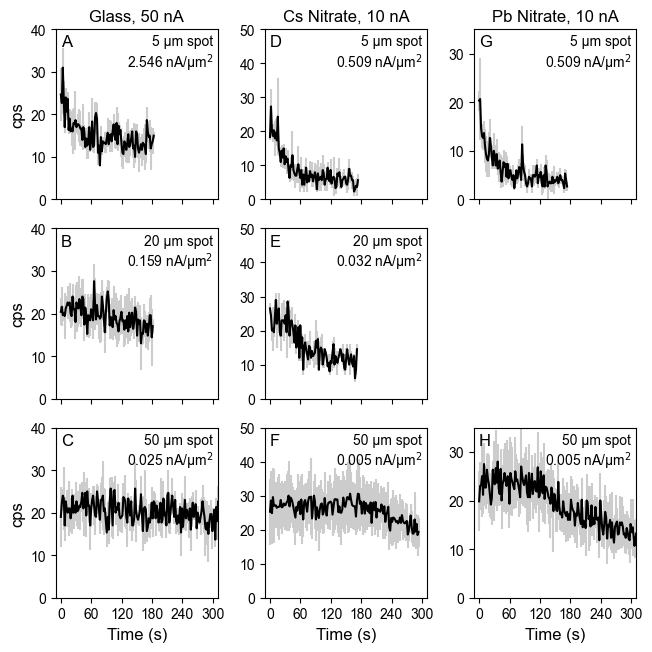

In [9]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(17*0.39, 17*0.39), sharex=True)
ax = ax.transpose().ravel() # We want to plot along columns rather than rows

alphalabel = 'ABCDEFGHIJ'

for i in range(len(data)):
    
    # Skip the middle right axis
    if i != 7:
        plt.sca(ax[i])
    else:
        plt.sca(ax[i+1])
        
    plt.errorbar(data=data[i], x='Time', y='mean', yerr='stdev', color='k', ecolor=(0.8, 0.8, 0.8))
    plt.text(0.03, 0.97, alphalabel[i], ha='left', va='top', transform=plt.gca().transAxes, fontsize=12)
    plt.text(0.97, 0.97, '{} µm spot\n{} nA/µm$^2$'.format(beamsize[i], current_density[i].round(3)),
               ha='right', va='top', transform=plt.gca().transAxes, fontsize=10)
    
for i in range(len(ax)):

    
    ax[i].set_xlim(-10, 310)
    ax[i].set_xticks(np.arange(0, 360, 60))
    
    if i in [0,1,2]:
        ax[i].set_ylabel('cps', fontsize=12)
        ax[i].set_ylim(0, 40)
    
    if i in [3,4,5]:
        ax[i].set_ylim(0, 50)
        
    if i in [6,7,8]:
        ax[i].set_ylim(0, 35)

    
    if i in [2,5,8]:
        ax[i].set_xlabel('Time (s)', fontsize=12)
        

ax[0].set_title('Glass, 50 nA')
ax[3].set_title('Cs Nitrate, 10 nA')
ax[6].set_title('Pb Nitrate, 10 nA')

ax[7].set_visible(False)


plt.tight_layout()

plt.savefig('../figures/fig_countlogs_glass_nitrates.pdf')